In [3]:
import os
import pandas as pd

In [4]:
cwd = os.getcwd()
cwd

'/home/connor/code/zulu-tango/news_and_echo_bubbles/notebooks'

In [5]:
parent = os.path.dirname(cwd)
parent

'/home/connor/code/zulu-tango/news_and_echo_bubbles'

In [6]:
data_folder = os.path.join(parent,"raw_data")
data_folder

'/home/connor/code/zulu-tango/news_and_echo_bubbles/raw_data'

In [7]:
left_data_location = os.path.join(data_folder,"braindedleft.csv")
right_data_location = os.path.join(data_folder,"braindedright.csv")

In [8]:
# load in left and right datasets
df_left = pd.read_csv(left_data_location)
df_right = pd.read_csv(right_data_location)

In [9]:
# assign a 0 to left wing articles and a 1 to right wing articles
df_left["ideology"] = 0
df_right["ideology"] = 1

In [196]:
# merge the two datasets
merged_df = pd.concat([df_left,df_right])

In [197]:
merged_df.head(1)

,Unnamed: 0,link,pdate,title,author,text,keywords,tags,compound,neg,neu,pos,polarity,subjectivity,ideology
0,0,https://kindest.com/442355-defend-democracy-to...,NaN,"Defend Democracy Today: Support Fearless, Insi...",[],"While the election has come and gone, the figh...","['reporting', 'come', 'today', 'access', 'chec...",set(),0.8612,0.063,0.819,0.118,0.165589,0.539782,0


In [198]:
merged_df.tail(1)

,Unnamed: 0,link,pdate,title,author,text,keywords,tags,compound,neg,neu,pos,polarity,subjectivity,ideology
1809,1809,https://americanmind.org/video/book-talk-crisi...,NaN,The American Mind Podcast: The Roundtable Epis...,"['Christopher Buskirk', 'Kevin Portteus', 'Dan...",The American Mind’s ‘Editorial Roundtable’ pod...,"['mind', 'williams', 'trump', 'american', 'unc...",set(),0.6808,0.026,0.9,0.074,0.114815,0.296296,1


In [199]:
# drop unnecessary columns
# we may not want to drop all of these for later analysis, but this is fine for now
merged_df = merged_df.drop(columns = ["Unnamed: 0", "link", "pdate", "title", "author",	"keywords",\
                          "tags", "compound", "neg", "neu", "pos", "polarity", "subjectivity"])

In [200]:
# taking a sample to make testing the model easier
df_sample = merged_df.sample(500)

In [201]:
# check data is balanced between left-wing and right-wing (i.e. c.250 of each class)
df_sample["ideology"].sum()

229

In [202]:
!pip install tensorflow transformers

In [203]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [204]:
df_sample.head()

,text,ideology
244,"Florida Gov. Ron DeSantis, promoting his decis...",0
2394,Subscribe to The Nation Subscribe now for as l...,0
2325,[music] This is a story about a guy and a term...,0
1417,The Commerce Department said Wednesday it has ...,1
1943,Let our journalists help you make sense of the...,0


In [205]:
# see what the lengths of the texts are
# need to convert to string first before calculating length as was getting an error that some review text cells were float values and not strings
df_sample["text_length"] = df_sample["text"].apply(lambda x: len(str(x)))

In [206]:
df_sample.head()

,text,ideology,text_length
244,"Florida Gov. Ron DeSantis, promoting his decis...",0,2466
2394,Subscribe to The Nation Subscribe now for as l...,0,16515
2325,[music] This is a story about a guy and a term...,0,13213
1417,The Commerce Department said Wednesday it has ...,1,2314
1943,Let our journalists help you make sense of the...,0,1555


In [207]:
df_sample = df_sample.dropna()
df_sample

,text,ideology,text_length
244,"Florida Gov. Ron DeSantis, promoting his decis...",0,2466
2394,Subscribe to The Nation Subscribe now for as l...,0,16515
2325,[music] This is a story about a guy and a term...,0,13213
1417,The Commerce Department said Wednesday it has ...,1,2314
1943,Let our journalists help you make sense of the...,0,1555
...,...,...,...
705,(CNN) Derek Chauvin's defense attorney Eric Ne...,0,1102
1448,BERLIN (AP) — German authorities are expected ...,1,2991
1523,“We have identified youth work as a priority f...,0,7803
1176,America has a deficit problem. But the country...,0,5255


In [208]:
# 34 rows were dropped in this, therefore a lot are NAN!!! Need to make sure to remove these!

In [209]:
import matplotlib.pyplot as plt

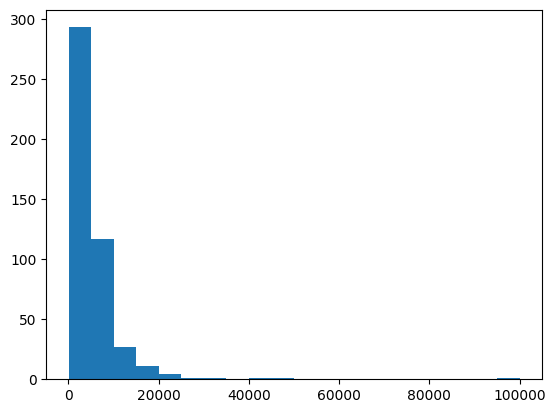

In [210]:
# view histogram of lengths of sample texts
plt.hist(df_sample["text_length"], bins = 20);

In [211]:
# let's say max length is 10,000 from this histogram

In [274]:
# import the tokenizer from DistilBert to tokenize our texts
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [213]:
df_sample.index

Index([ 244, 2394, 2325, 1417, 1943,  694, 1593,  838,  155,  294,
       ...
       1814, 1691, 1907,   74,  539,  705, 1448, 1523, 1176,  190],
      dtype='int64', length=457)

In [215]:
df_sample = df_sample.reset_index(drop=True)
df_sample

,text,ideology,text_length
0,"Florida Gov. Ron DeSantis, promoting his decis...",0,2466
1,Subscribe to The Nation Subscribe now for as l...,0,16515
2,[music] This is a story about a guy and a term...,0,13213
3,The Commerce Department said Wednesday it has ...,1,2314
4,Let our journalists help you make sense of the...,0,1555
...,...,...,...
452,(CNN) Derek Chauvin's defense attorney Eric Ne...,0,1102
453,BERLIN (AP) — German authorities are expected ...,1,2991
454,“We have identified youth work as a priority f...,0,7803
455,America has a deficit problem. But the country...,0,5255


In [218]:
len(df_sample["text"][0])

2466

In [275]:
# example embedding with max length of 10,000
example_embedding = tokenizer(df_sample["text"][0], max_length = 10_000, truncation = True, padding = True)
example_embedding

{'input_ids': [101, 3516, 18079, 1012, 6902, 4078, 4630, 2483, 1010, 7694, 2010, 3247, 2000, 2128, 26915, 2270, 2816, 2005, 1999, 1011, 2711, 4280, 1010, 2038, 3555, 2008, 1996, 2522, 17258, 1011, 2539, 8985, 6165, 2426, 3516, 2082, 19339, 7389, 2024, 8052, 2135, 2659, 1012, 2021, 2429, 2000, 1059, 2102, 3501, 2615, 3149, 1020, 1010, 1996, 6788, 2547, 8727, 1999, 5631, 1010, 4078, 4630, 2483, 2038, 15486, 2000, 5254, 2129, 2216, 8985, 6165, 2941, 12826, 2000, 2060, 2163, 1012, 6788, 1020, 6398, 4116, 28315, 9956, 2638, 7607, 1010, 1000, 2023, 2733, 1010, 1996, 6788, 1020, 14766, 2179, 1010, 2002, 3807, 28616, 3709, 1996, 2270, 2055, 2129, 3516, 20829, 2039, 2000, 2060, 2163, 2043, 2009, 3310, 2000, 8985, 6165, 2426, 2082, 1011, 2287, 2336, 1012, 2076, 7928, 6928, 12559, 14083, 2075, 8037, 2005, 1010, 2002, 3555, 1010, 5128, 5089, 1005, 9209, 1005, 3805, 1997, 1996, 2092, 1011, 2108, 1997, 2256, 2336, 1010, 1005, 2002, 2000, 12926, 2129, 2092, 3516, 5123, 2082, 2336, 2013, 1996, 7865, 1

In [219]:
import numpy as np

In [220]:
# define our x and y from the dataset
x = df_sample["text"].array
y = df_sample["ideology"].array

In [221]:
# convert x to strings as some are just floats (this should be fixed anyway during pre-processing)
x = [str(x) for row in x]

In [276]:
# using a max_len of 50 here to save time making the encodings
# this took a VERY long time
def construct_encodings(x, tokenizer, max_len=50, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(x, tokenizer)

In [277]:
# turning into a tensor (though I am not sure why)
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, y)

In [278]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [279]:
N_EPOCHS = 10

model = TFDistilBertF
orSequenceClassification.from_pretrained('distilbert-base-uncased')
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
183/183 [==============================] - 146s 684ms/step - loss: 0.6851 - accuracy: 0.5918
Epoch 2/10
183/183 [==============================] - 123s 673ms/step - loss: 0.6881 - accuracy: 0.5671
Epoch 3/10
183/183 [==============================] - 123s 673ms/step - loss: 0.6769 - accuracy: 0.6000
Epoch 4/10
183/183 [==============================] - 123s 671ms/step - loss: 0.6792 - accuracy: 0.5973
Epoch 5/10
183/183 [==============================] - 123s 670ms/step - loss: 0.6790 - accuracy: 0.5973
Epoch 6/10
183/183 [==============================] - 125s 682ms/step - loss: 0.6733 - accuracy: 0.6055
Epoch 7/10
183/183 [==============================] - 125s 683ms/step - loss: 0.6683 - accuracy: 0.6055
Epoch 8/10
183/183 [==============================] - 125s 681ms/step - loss: 0.6763 - accuracy: 0.6055
Epoch 9/10
183/183 [==============================] - 125s 684ms/step - loss: 0.6853 - accuracy: 0.5863
Epoch 10/10
183/183 [==============================] - 125s 684m

In [280]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

46/46 [==============================] - 6s 97ms/step - loss: 0.6938 - accuracy: 0.5435
{'loss': 0.6937775611877441, 'accuracy': 0.54347825050354}


In [ ]:
# the accuracy is not very good, as it is only 0.54. Baseline accuracy = 0.5
# could probably improve the accuracy by increasing the length of each article? (currently set to 50 words)
# accuracy will also be increased with better text preprocessing?
# accuracy could also be increased with more epochs (but this takes a long time) - could train on google Colab instead?
# should also set it up so that it uses validation splits in the model compilation?

## next steps:
### see if there are other models which perform better?

In [10]:
from urllib.parse import urlsplit

In [11]:
# create a new column in the left df with the base URL, stripped of any "www." prefix for clarity
df_left["base_url"] = df_left["link"].apply(lambda x: urlsplit(x).netloc.removeprefix("www."))

In [12]:
# convert this column into a list
left_urls = df_left["base_url"].tolist()

In [13]:
# get an alphabetically-sorted list of the unique base URLs by converting into a set
unique_left_urls = sorted(list(set(left_urls)))
len(unique_left_urls)

352

In [14]:
# do the same below with the right df

In [15]:
df_right["base_url"] = df_right["link"].apply(lambda x: urlsplit(x).netloc.removeprefix("www."))

In [16]:
right_urls = df_right["base_url"].tolist()

In [17]:
unique_right_urls = sorted(list(set(right_urls)))
len(unique_right_urls)

95

In [18]:
# see if there is any overlap between the lists?
overlap = set(unique_left_urls) & set(unique_right_urls)
overlap

{'apnews.com',
 'bbc.com',
 'bloomberg.com',
 'breitbart.com',
 'businessinsider.com',
 'denverpost.com',
 'en.wikipedia.org',
 'foxnews.com',
 'gizmodo.com',
 'latimes.com',
 'news.yahoo.com',
 'newsweek.com',
 'npr.org',
 'nypost.com',
 'nytimes.com',
 'politico.com',
 'reuters.com',
 'slate.com',
 'theatlantic.com',
 'theconversation.com',
 'thehill.com',
 'usatoday.com',
 'vox.com',
 'vulture.com',
 'washingtonpost.com',
 'wsj.com'}

In [19]:
len(overlap)

26

In [20]:
### can therefore see that there are 26 base URLs where some news articles are considered "right" and some are considered "left"
# this seems a little odd - for example, the far-right publication Breitart is considered both "left" and "right"

In [22]:
unique_left_urls

['12news.com',
 '19thnews.org',
 'abcnews.go.com',
 'aboutamazon.com',
 'academic.oup.com',
 'actionnetwork.org',
 'advancementproject.org',
 'agriculture.com',
 'ajc.com',
 'ajpmonline.org',
 'al.com',
 'aljazeera.com',
 'alternet.org',
 'america.aljazeera.com',
 'americanmanufacturing.org',
 'americanprogress.org',
 'americanrivers.org',
 'americansecurityproject.org',
 'americasvoice.org',
 'amnesty.org',
 'anchor.fm',
 'andylevinforcongress.com',
 'apnews.com',
 'axios.com',
 'azcentral.com',
 'azmirror.com',
 'ballotpedia.org',
 'baltimoresun.com',
 'bandyxlee.medium.com',
 'bbc.com',
 'beta.documentcloud.org',
 'bigthink.com',
 'billfrisell.com',
 'billmoyers.com',
 'blogs.lse.ac.uk',
 'blogs.scientificamerican.com',
 'bloomberg.com',
 'bloomsbury.com',
 'bloomsburycollections.com',
 'bonappetit.com',
 'breitbart.com',
 'briarpatchmagazine.com',
 'brookings.edu',
 'business-standard.com',
 'businessinsider.com',
 'businesstoday.in',
 'buzzfeednews.com',
 'catalyst-journal.com',
 